In [ ]:
# import pandas as pd
# import numpy as np

# # Assuming your dataframe is named 'df' and the column containing labels is named 'label'
# # Select 1000 random data points from class 0
# class_0_sample = df[df['label'] == 0].sample(n=1000, random_state=42)

# # Select all data points from class 1
# class_1_sample = df[df['label'] == 1].sample(n=1000, random_state=42)

# # Concatenate the samples
# sampled_df = pd.concat([class_0_sample, class_1_sample])

# # Shuffle the dataframe
# sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# # Verify the class distribution
# print(sampled_df['label'].value_counts())

# # Now sampled_df contains 1000 random data points from each class


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
# Replace 'your_dataset.csv' with the path to your dataset file
df = pd.read_csv('aihu.csv')

In [5]:
df.head(4)
#0 - human 
#1 - ai

,text,class
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1


In [3]:
# df.rename(columns = {'Data':'text'}, inplace = True) 
df.rename(columns = {'generated':'class'}, inplace = True) 

In [4]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Check for class balance
print("\nClass distribution:")
print(df['class'].value_counts())

# Basic preprocessing: removing missing values
# This step might be expanded based on the dataset's characteristics
df.dropna(inplace=True)

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['class'], test_size=0.2, random_state=42)

# Output the size of the splits
print("\nTraining set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


Missing values in each column:
text     0
class    0
dtype: int64

Class distribution:
class
0    17508
1    11637
Name: count, dtype: int64

Training set size: 23316
Testing set size: 5829


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set maximum number of words to keep, based on word frequency
MAX_WORDS = 10000  # This is adjustable
MAX_SEQUENCE_LENGTH = 250  # Max length of each sequence, adjustable based on dataset characteristics

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print("Shape of training data:", X_train_padded.shape)
print("Shape of testing data:", X_test_padded.shape)

2024-03-24 19:24:50.516515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 19:24:50.516562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 19:24:50.518482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 19:24:50.530467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shape of training data: (23316, 250)
Shape of testing data: (5829, 250)


In [8]:
import numpy as np

# Calculate simple linguistic features
X_train_lengths = np.array([len(text.split()) for text in X_train])  # Text length
X_train_avg_word_length = np.array([np.mean([len(word) for word in text.split()]) for text in X_train])  # Average word length

X_test_lengths = np.array([len(text.split()) for text in X_test])
X_test_avg_word_length = np.array([np.mean([len(word) for word in text.split()]) for text in X_test])

# Stack features together for MLP input
X_train_features = np.vstack((X_train_lengths, X_train_avg_word_length)).T
X_test_features = np.vstack((X_test_lengths, X_test_avg_word_length)).T


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# Model parameters
VOCAB_SIZE = min(MAX_WORDS, len(tokenizer.word_index) + 1)  # Vocabulary size
EMBEDDING_DIM = 100  # Size of the embedding vectors (can be adjusted)
FILTERS = 128  # Number of filters for the Conv layer
KERNEL_SIZE = 5  # Size of the kernel for the Conv layer
DENSE_UNITS = 10  # Number of units in the Dense layer

# Model definition
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(FILTERS, KERNEL_SIZE, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(DENSE_UNITS, activation='relu'),
    Dense(1, activation='sigmoid')  # For binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          1000000   
                                                                 
 conv1d (Conv1D)             (None, 246, 128)          64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1065429 (4.06 MB)
Trainable params: 1065429 (4.06 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

2024-03-24 19:27:30.161136: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9611 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5
2024-03-24 19:27:30.162523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9491 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5
2024-03-24 19:27:30.163709: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9491 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:87:00.0, compute capability: 7.5
2024-03-24 19:27:30.164910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 7285 MB memory:  -> device: 3, name: NVIDIA GeForce GTX

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Dense
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Flatten

# CNN part for text
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
text_features = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(text_input)
text_features = Conv1D(FILTERS, KERNEL_SIZE, activation='relu')(text_features)
text_features = GlobalMaxPooling1D()(text_features)

# MLP part for linguistic features
linguistic_input = Input(shape=(X_train_features.shape[1],))
linguistic_features = Dense(DENSE_UNITS, activation='relu')(linguistic_input)

# Concatenate the outputs of the two models
combined_features = concatenate([text_features, linguistic_features])

# Final classification layer
classification_output = Dense(1, activation='sigmoid')(combined_features)

model = Model(inputs=[text_input, linguistic_input], outputs=classification_output)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 250, 100)             1000000   ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 246, 128)             64128     ['embedding_1[0][0]']         
                                                                                                  
 input_2 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                              

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

# Train the model
history = model.fit([X_train_padded, X_train_features], y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=([X_test_padded, X_test_features], y_test),
                    callbacks=[early_stopping])

# Note: The batch_size and epochs are set to small numbers for demonstration and might need adjustment.


Epoch 1/10


2024-03-24 19:35:04.497456: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-24 19:35:04.698515: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-24 19:35:05.024745: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-24 19:35:06.130633: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f29085060f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-24 19:35:06.130686: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-03-24 19:35:06.130701: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-03-24 19:35:06.130710: I external/local_xla/xla/service/service.cc:176]   

729/729 [==============================] - 97s 126ms/step - loss: 0.3965 - accuracy: 0.9263 - val_loss: 0.0369 - val_accuracy: 0.9875
Epoch 2/10
729/729 [==============================] - 27s 37ms/step - loss: 0.0213 - accuracy: 0.9941 - val_loss: 0.0241 - val_accuracy: 0.9902
Epoch 3/10
729/729 [==============================] - 16s 23ms/step - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.0208 - val_accuracy: 0.9913
Epoch 4/10
729/729 [==============================] - 10s 14ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 0.9913
Epoch 5/10
729/729 [==============================] - 10s 14ms/step - loss: 2.8443e-04 - accuracy: 1.0000 - val_loss: 0.0197 - val_accuracy: 0.9918
Epoch 6/10
729/729 [==============================] - 9s 12ms/step - loss: 1.4280e-04 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 0.9916
Epoch 7/10
729/729 [==============================] - 10s 14ms/step - loss: 8.3350e-05 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy

183/183 [==============================] - 1s 3ms/step - loss: 0.0192 - accuracy: 0.9913
Test Accuracy: 99.13%


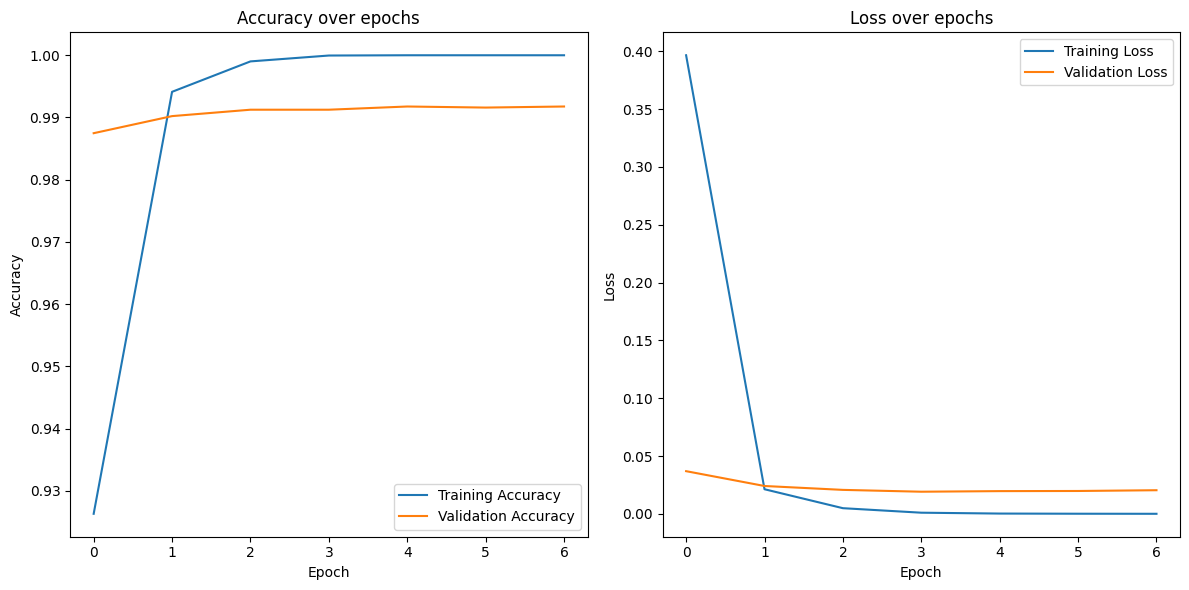

In [11]:
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([X_test_padded, X_test_features], y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Plotting training history
def plot_history(history):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)



In [13]:
def predict_text(text):
    # Tokenize and pad the input text
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    
    # Simulate the linguistic features for the input text
    # Here, we're using the same basic features: text length and average word length
    text_length = len(text.split())
    avg_word_length = np.mean([len(word) for word in text.split()])
    features = np.array([[text_length, avg_word_length]])
    
    # Make a prediction
    prediction = model.predict([padded_seq, features])
    
    # Interpret the prediction
    if prediction >= 0.5:
        print("The text is predicted to be an AI Generated Essay.")
    else:
        print("The text is predicted to be a Human Written Essay.")

# Example usage
user_input = input("Please enter a sentence to classify: ")
predict_text(user_input)


Please enter a sentence to classify:  I find it difficult to impose any sort of rigid cartographic principles on most of these. For example, the Fra Mauro map seems to duplicate labels liberally to show extent. There are 2 labels for Europe and 3 for Asia. Not to mention 2 Egypts, 2 Mesopotamias, 2 Tartarias etc.For the Waldseem√ºller map, the principle seems to be finding empty space, so Europe has the smallest letters of all the major land-masses, and the most dispersed (I also can't find the 'EU'). But like with Asia, Africa has been set in an essentially empty section of the map. It also has the province of Africa and Libya... so I'm with you on the problem of how to interpret 'Libya Inferior'. It seems to denote an intermediate sized region along the lines of Ethiopia. But we find duplications in medieval mappaemundi as well. The Ebstorf Map, for example, has Africa written in large capitals across the landmass, but also has 'Africa' written in small caps under the 'A' of Africa, 

1/1 [==============================] - 0s 45ms/step
The text is predicted to be a Human Written Essay.


In [14]:
user_input = input("Please enter a sentence to classify: ")
predict_text(user_input)

Please enter a sentence to classify:  In 1850, traveling from London to British India would have been a long and arduous journey, but it was indeed possible for someone in your situation to make the trip. However, it's important to note that traveling to India would not guarantee adventure and fortune. It was a challenging and unfamiliar environment, and success was not guaranteed for everyone.


1/1 [==============================] - 0s 43ms/step
The text is predicted to be an AI Generated Essay.
